In [1]:
import torch
import itertools

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import Counter
from matplotlib.gridspec import GridSpec
from sklearn.datasets import load_diabetes
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler, minmax_scale

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

In [3]:
# model = 'baseline_model_diabetes'
model='soft_dot_penalised_model_diabetes'
k = 64 # size of nonlinear layer
log2_batch_size = 8
log2_training_steps = 18
# sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
# task = 'autoencoder'
decay = 0.0
# eps = 0.015625
m = 10 # input dimensions
# N = 10 # number of features
reg = 0.0
# lr = 0.001

step_size = .05
clist=('#4357AD', '#48A9A6', '#D4B483', '#C1666B', '#A53860')

In [4]:
names = list([
    f"../my_models/{model}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_init_bias_{init_bias}_decay_{decay}_m_{m}_reg_{reg}.pt"
    for lr in [0.001,0.003,0.005,0.007,0.01,0.03]])

In [5]:
batch = torch.load(names[-1], map_location=torch.device('cpu'))

d = batch['log2_spaced_models'][-1]
print(d['2.weight'].shape[0], m)
print(d['0.weight'].shape[1], m)
print(d['0.weight'].shape[0], k)
model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

1 10
10 10
64 64


Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=False)
)

In [6]:
vs = torch.eye(m)
sfa = model[:2].forward(vs).T.detach().numpy()
unit_sfa = np.array(sfa > 0.0, dtype='int')

In [7]:
where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]
mono_d = deepcopy(batch['log2_spaced_models'][-1])
mono_d['0.weight'][where_poly, :] *= 0
mono_d['0.bias'][where_poly] *= 0
mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                           d['0.weight'].shape[0], batch['nonlinearity'])
mono_model.load_state_dict(mono_d)
mono_model.to('cpu')

where_mono = np.where(np.sum(unit_sfa, axis=-1) == 1)[0]
poly_d = deepcopy(batch['log2_spaced_models'][-1])
poly_d['0.weight'][where_mono, :] *= 0
poly_d['0.bias'][where_mono] *= 0
poly_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1],
                           d['0.weight'].shape[0], batch['nonlinearity'])
poly_model.load_state_dict(poly_d)
poly_model.to('cpu')

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=False)
)

In [8]:
diabetes = load_diabetes()
inputs, vectors = diabetes.data, diabetes.target
scaler = StandardScaler().fit(inputs)
inputs = scaler.transform(inputs)
vectors = minmax_scale(vectors)

min_i, max_i = np.min(inputs), np.max(inputs)

In [9]:
full_os = []
mono_os = []
poly_os = []
for a in np.arange(min_i - step_size, max_i + 2*step_size, step_size):
    ins = torch.eye(m) * a
    full_os.append(model.forward(ins).T.detach().numpy()[0])
    mono_os.append(mono_model.forward(ins).T.detach().numpy()[0])
    poly_os.append(poly_model.forward(ins).T.detach().numpy()[0])

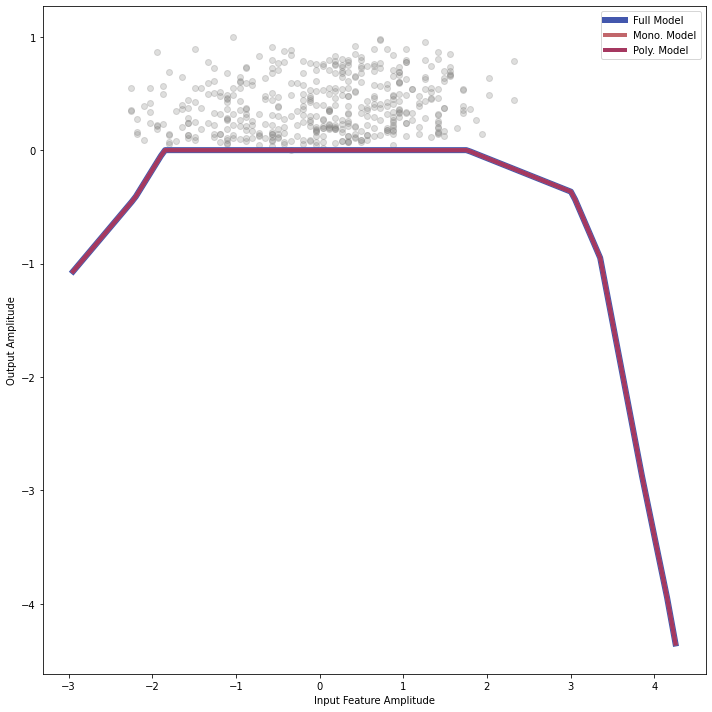

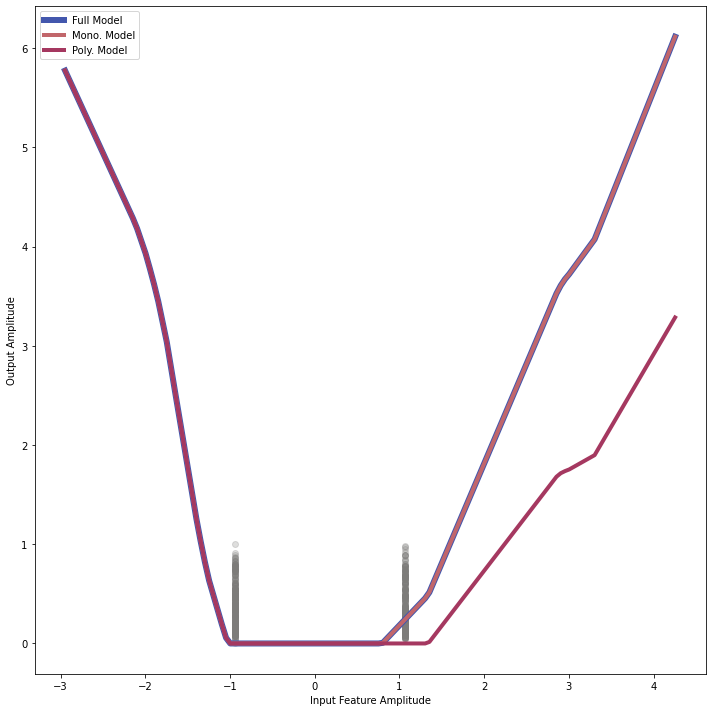

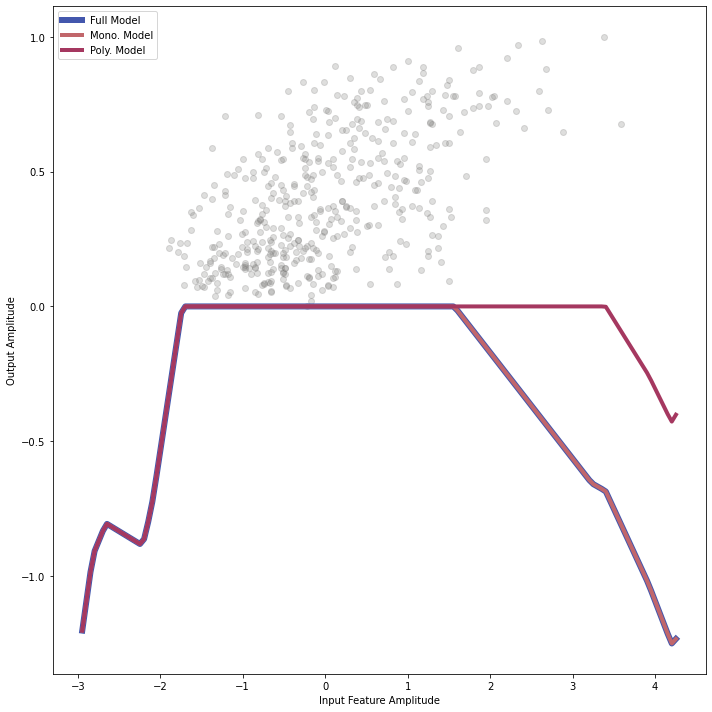

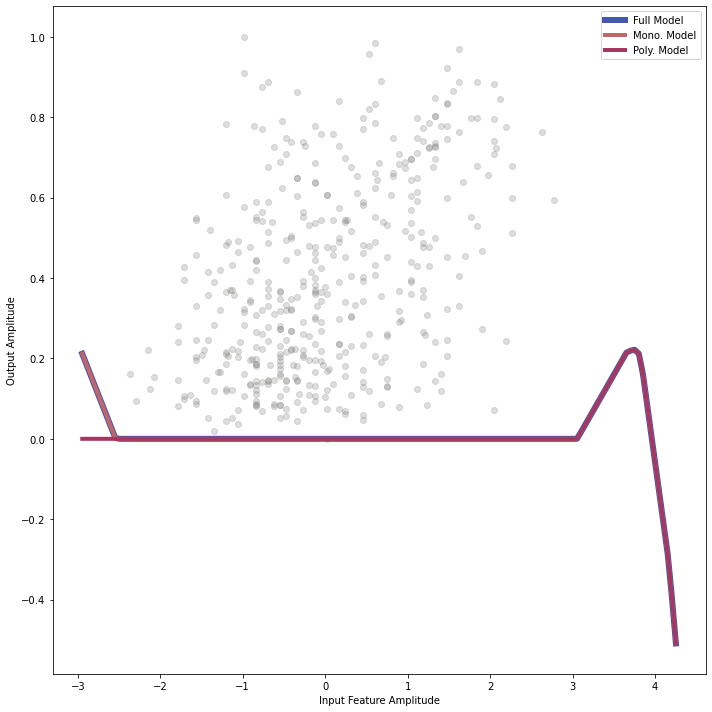

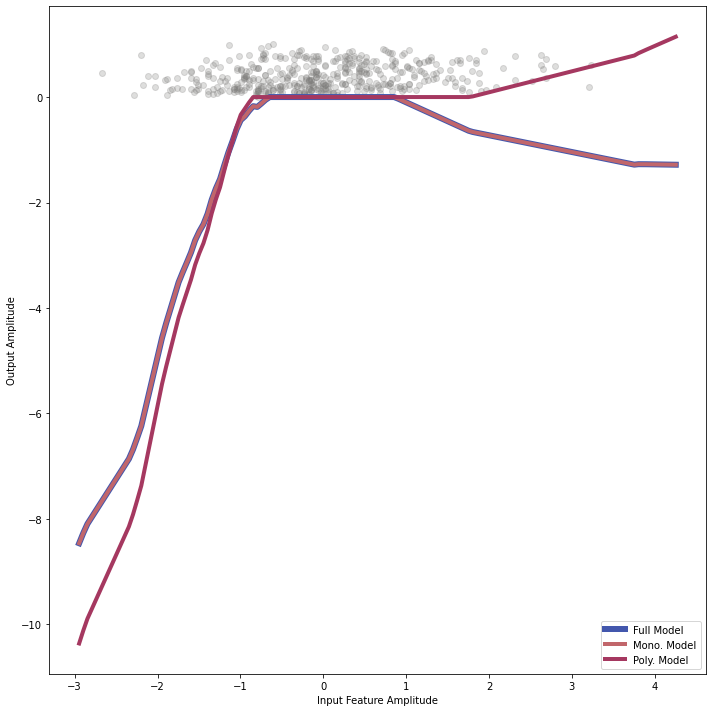

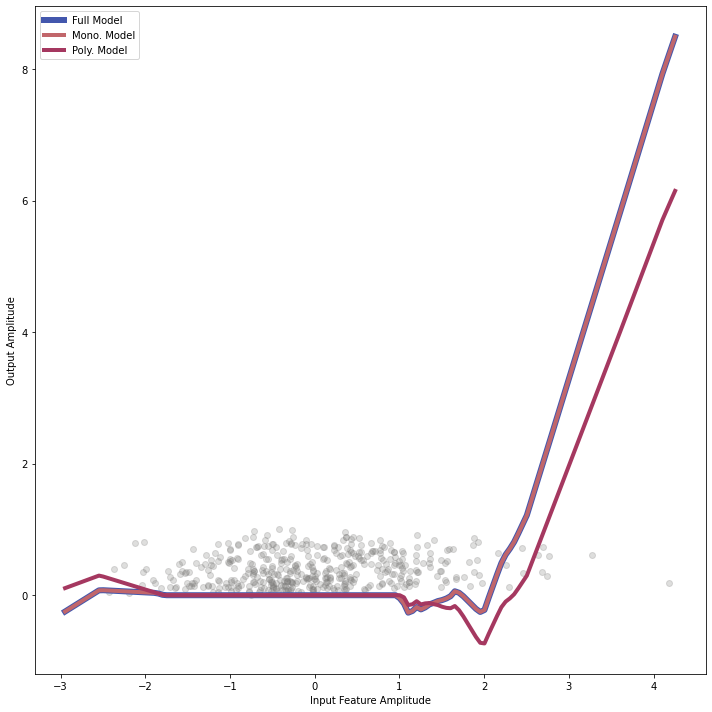

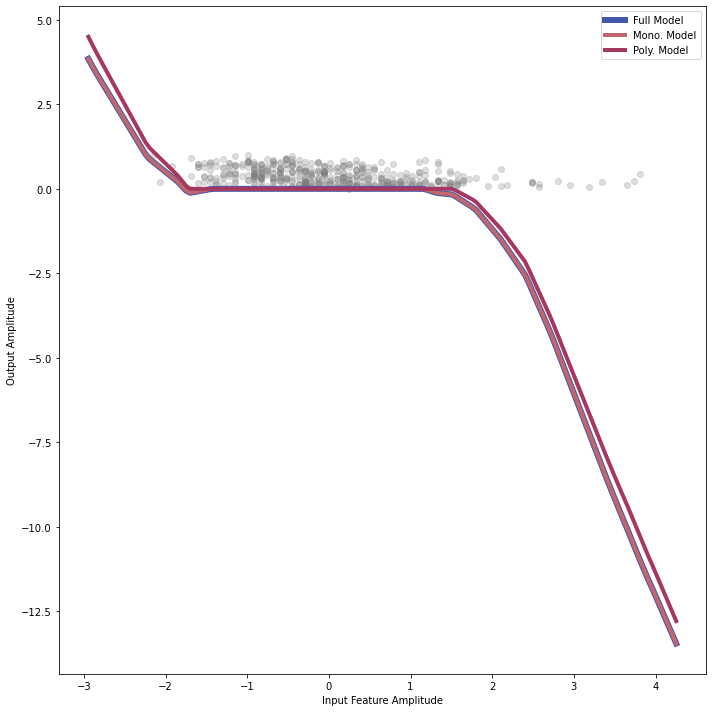

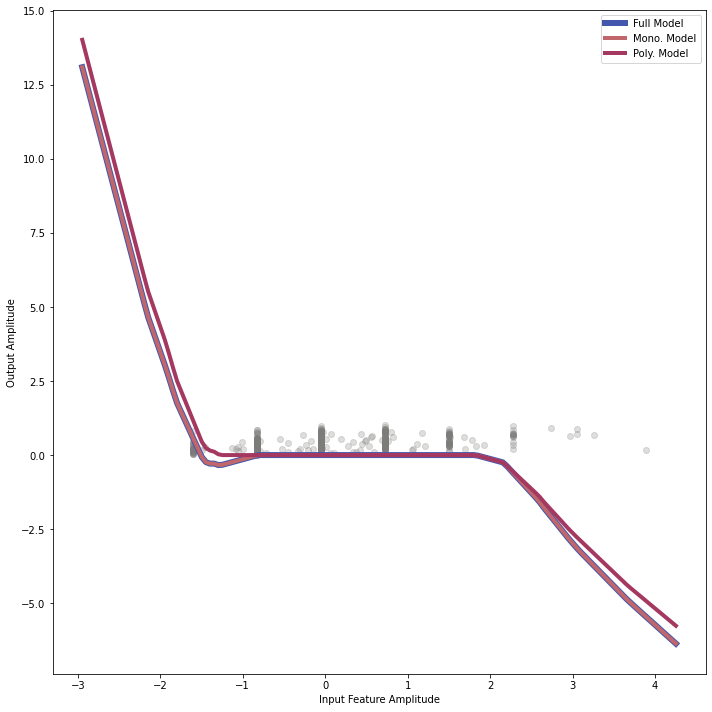

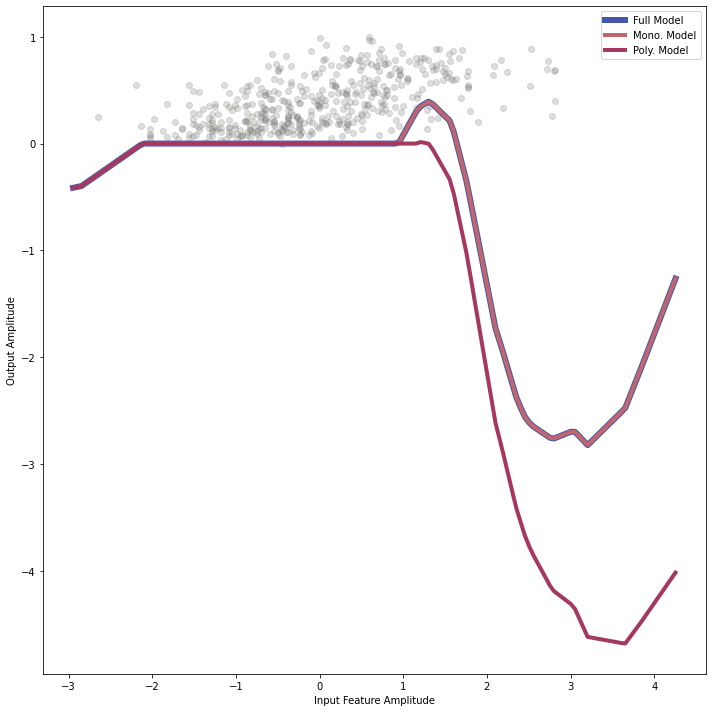

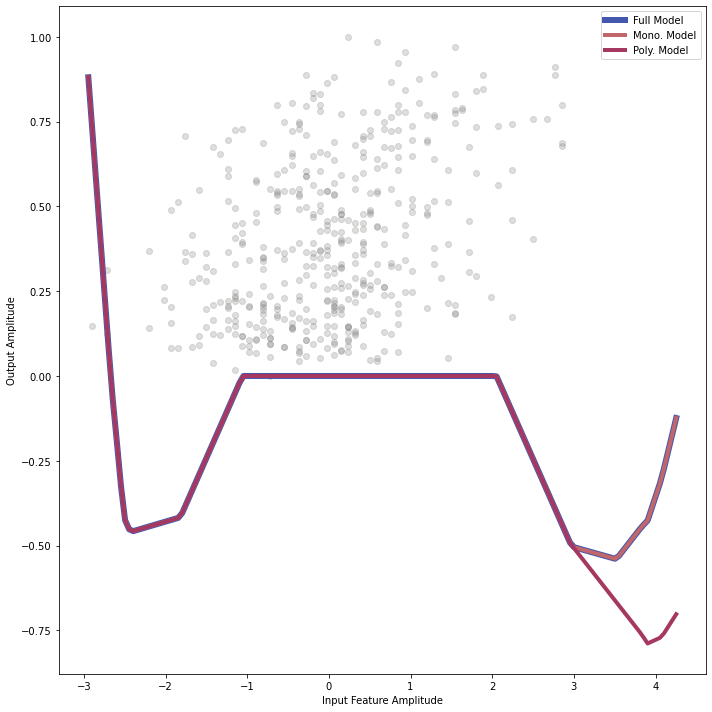

In [10]:
full_os = np.array(full_os)
mono_os = np.array(mono_os)
poly_os = np.array(poly_os)

for i in range(m):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(inputs[:, i], vectors, color='#7D7C7A', alpha=0.25)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), full_os[:,i], '-',
             label='Full Model', color=clist[0], lw=6)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), mono_os[:,i], '-',
             label='Mono. Model', color=clist[3], lw=4)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), poly_os[:,i], '-',
             label='Poly. Model', color=clist[4], lw=4)
    # plt.plot([0, 1], [0, 1], 'k--', label='Truth')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.xlabel('Input Feature Amplitude')
    plt.ylabel('Output Amplitude')
    plt.legend()
    
    fig.tight_layout()
    plt.show()

In [11]:
full_os = []
mono_os = []
poly_os = []
for i in range(m):
    ins = torch.tensor(inputs[inputs[:,i].argsort()], dtype=torch.float32)
    full_os.append(model.forward(ins).T.detach().numpy()[0])
    mono_os.append(mono_model.forward(ins).T.detach().numpy()[0])
    poly_os.append(poly_model.forward(ins).T.detach().numpy()[0])

(10, 442)
(442, 10)


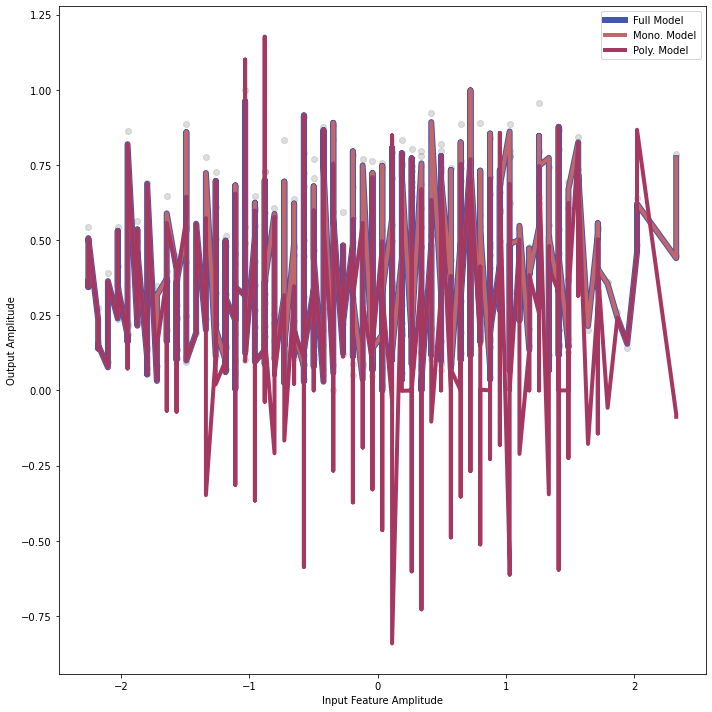

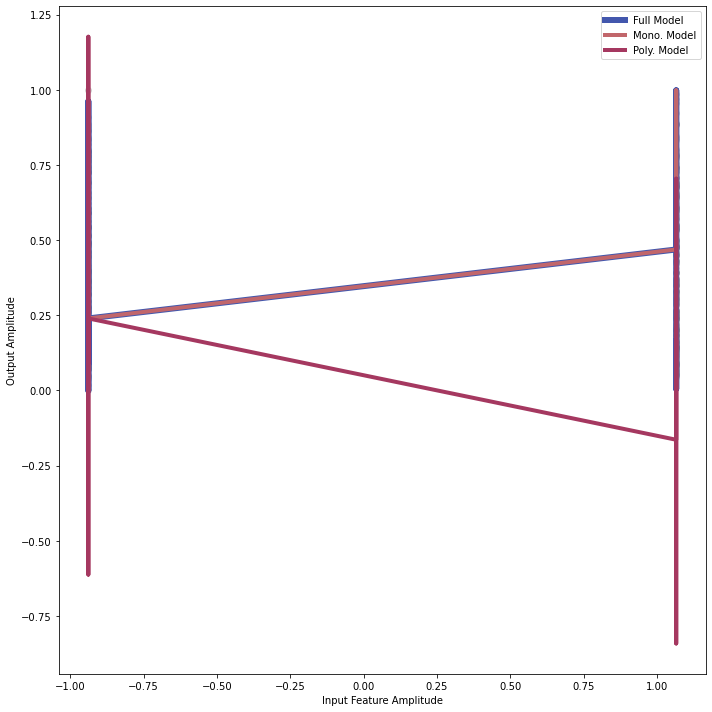

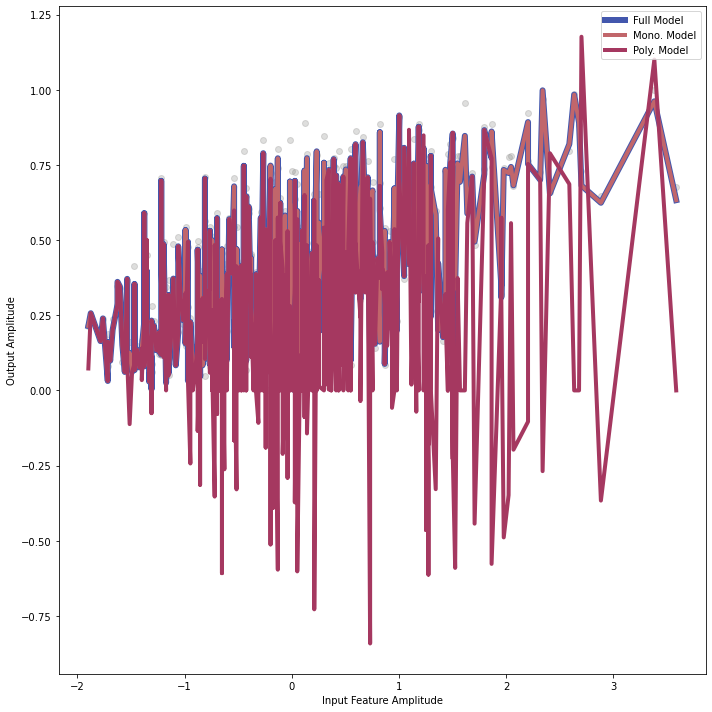

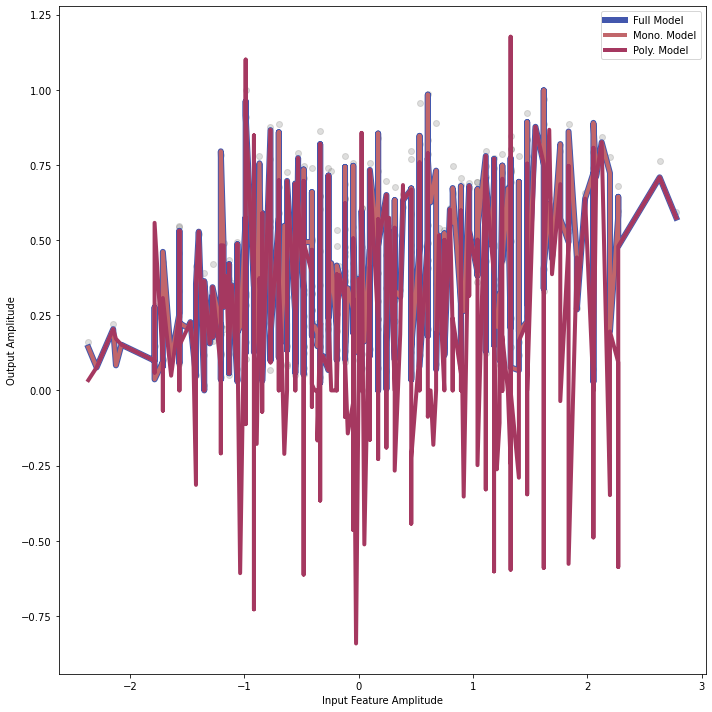

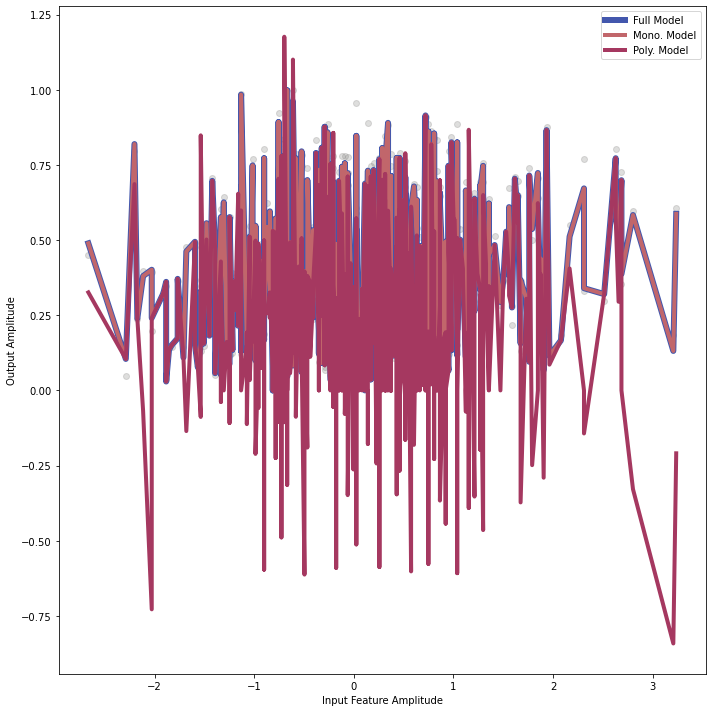

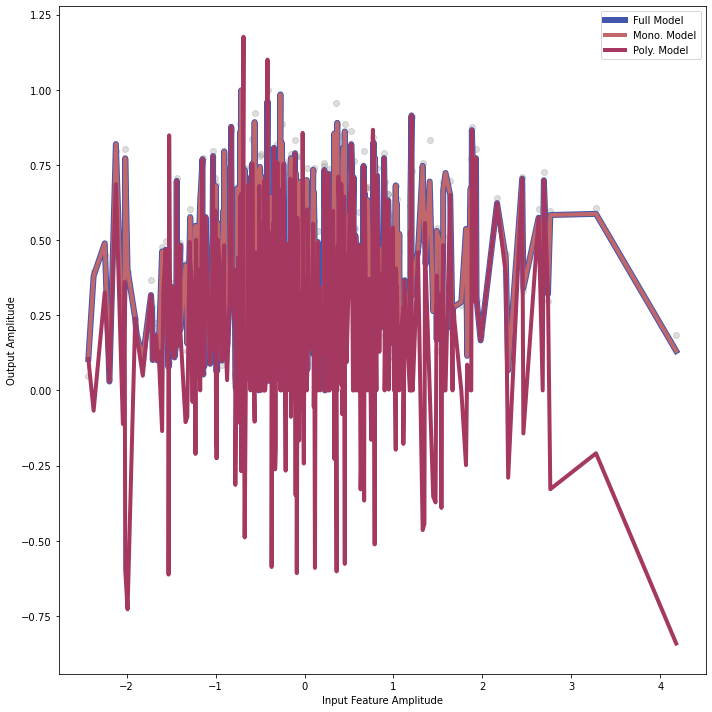

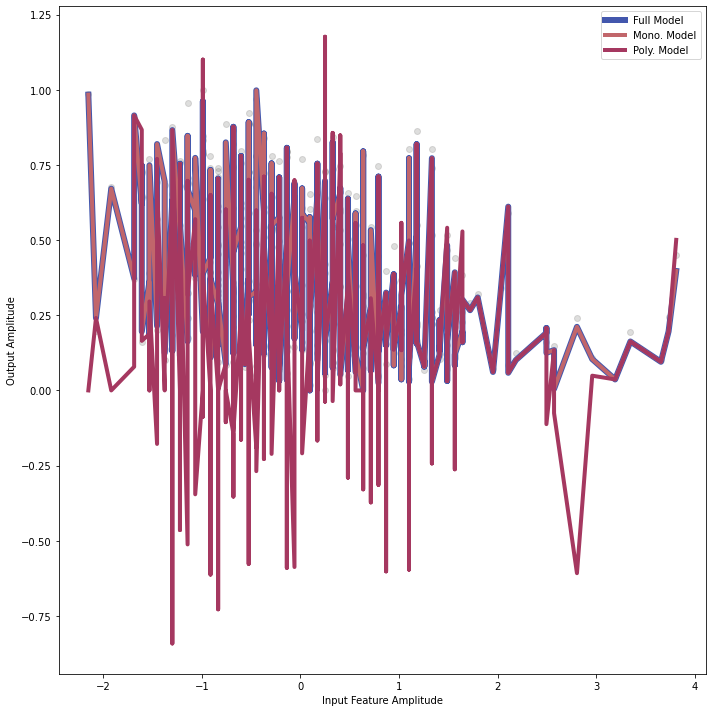

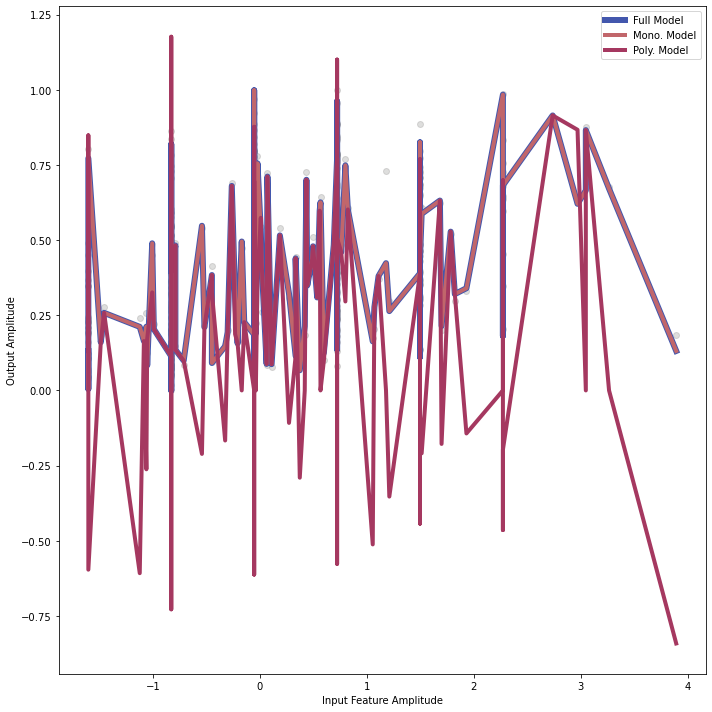

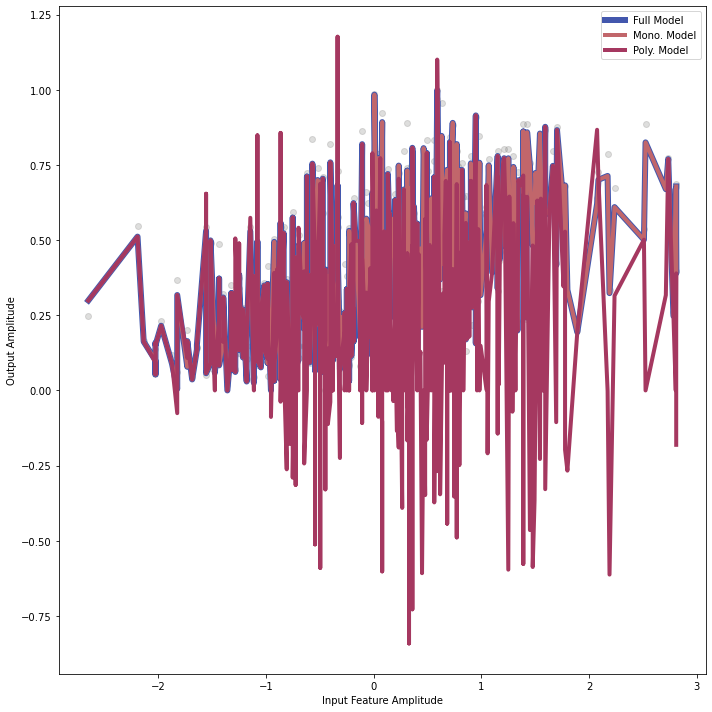

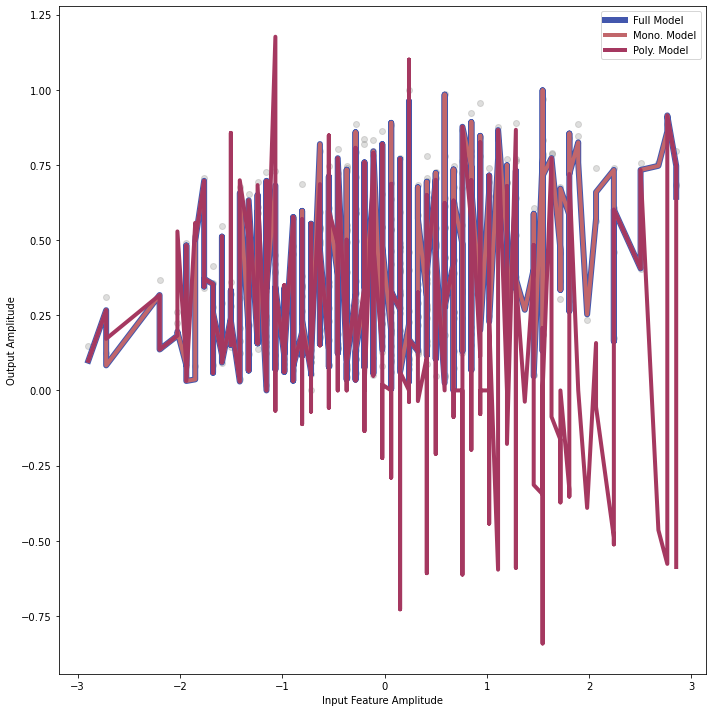

In [12]:
full_os = np.array(full_os)
mono_os = np.array(mono_os)
poly_os = np.array(poly_os)

print(full_os.shape)
print(inputs.shape)

for i in range(m):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(inputs[:, i], vectors, color='#7D7C7A', alpha=0.25)
    plt.plot(inputs[inputs[:,i].argsort()][:,i], full_os[i,:], '-',
             label='Full Model', color=clist[0], lw=6)
    plt.plot(inputs[inputs[:,i].argsort()][:,i], mono_os[i,:], '-',
             label='Mono. Model', color=clist[3], lw=4)
    plt.plot(inputs[inputs[:,i].argsort()][:,i], poly_os[i,:], '-',
             label='Poly. Model', color=clist[4], lw=4)
    # plt.plot([0, 1], [0, 1], 'k--', label='Truth')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.xlabel('Input Feature Amplitude')
    plt.ylabel('Output Amplitude')
    plt.legend()
    
    fig.tight_layout()
    plt.show()

In [13]:
full_os = []
mono_os = []
poly_os = []
for a in np.arange(min_i - step_size, max_i + 2*step_size, step_size):
    ins = torch.ones(m, m) * a
    full_os.append(model.forward(ins).T.detach().numpy()[0])
    mono_os.append(mono_model.forward(ins).T.detach().numpy()[0])
    poly_os.append(poly_model.forward(ins).T.detach().numpy()[0])

(145, 10)


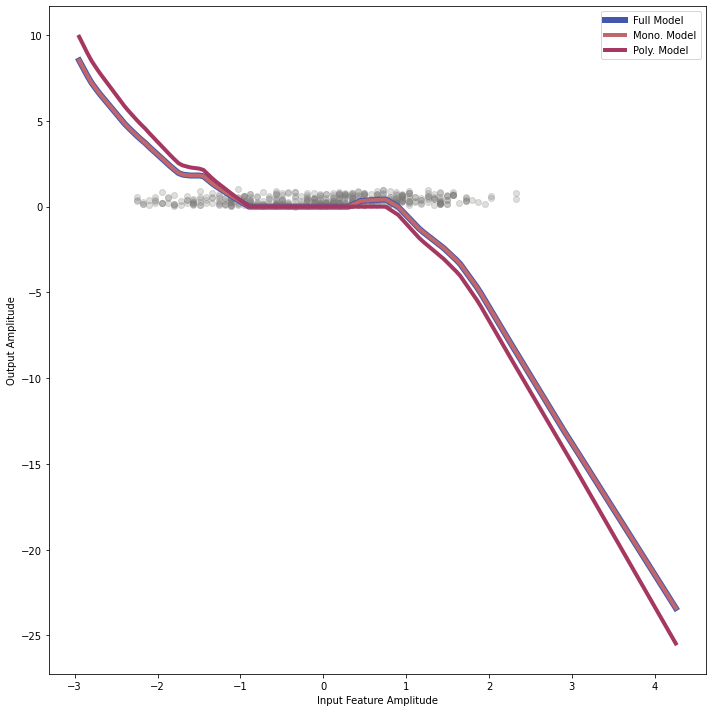

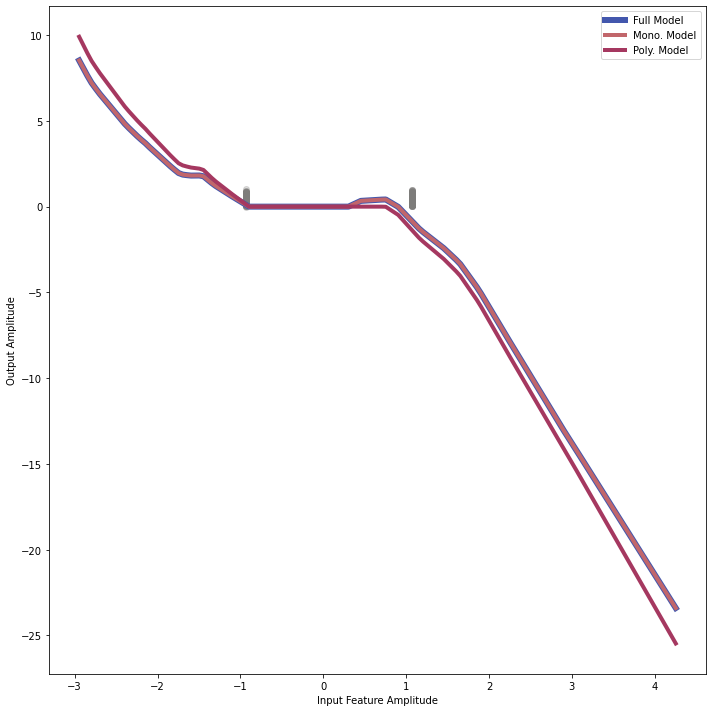

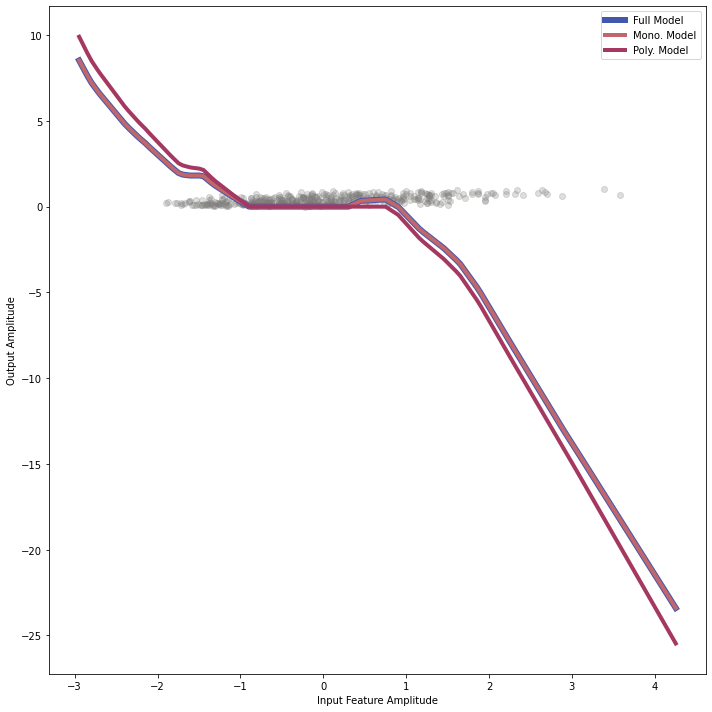

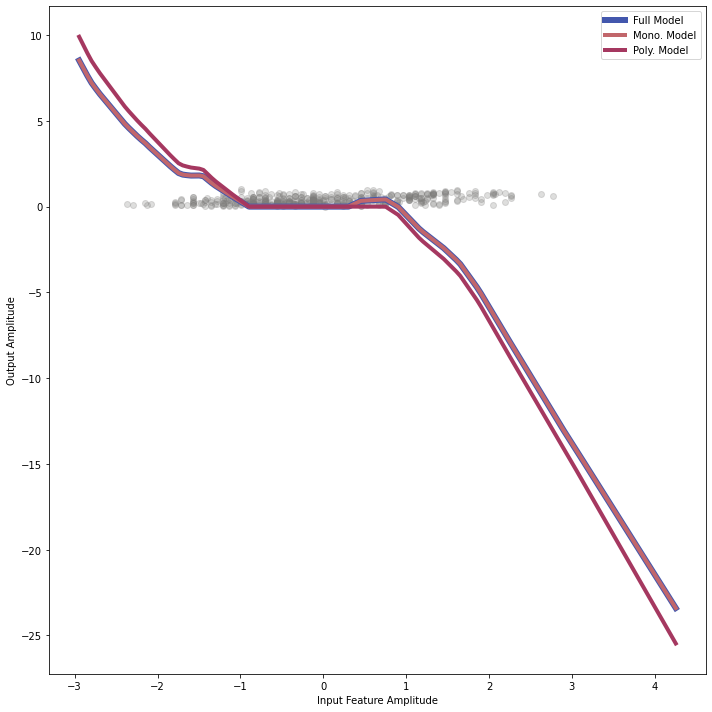

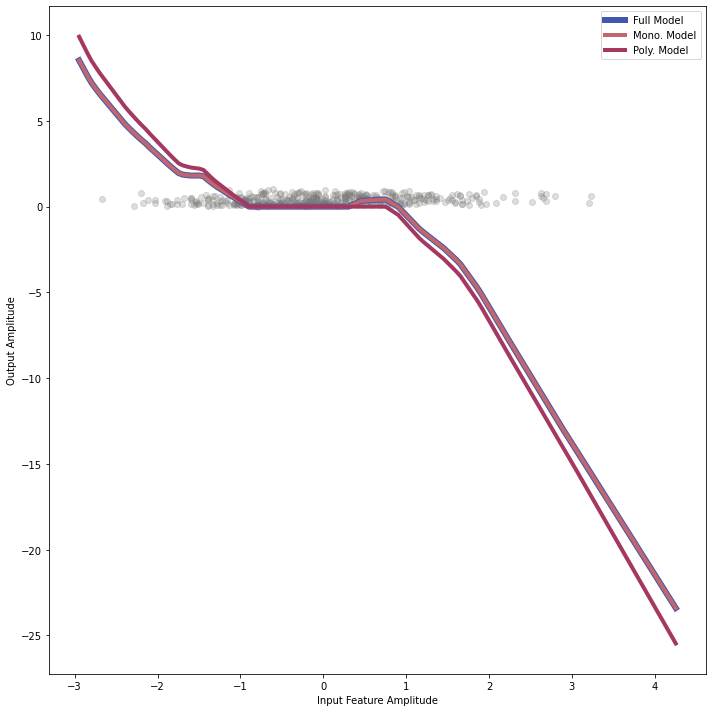

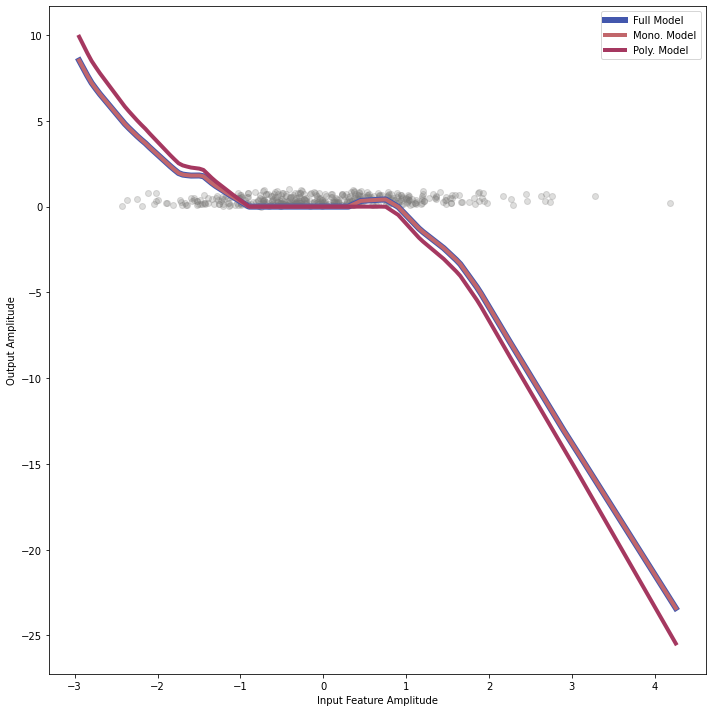

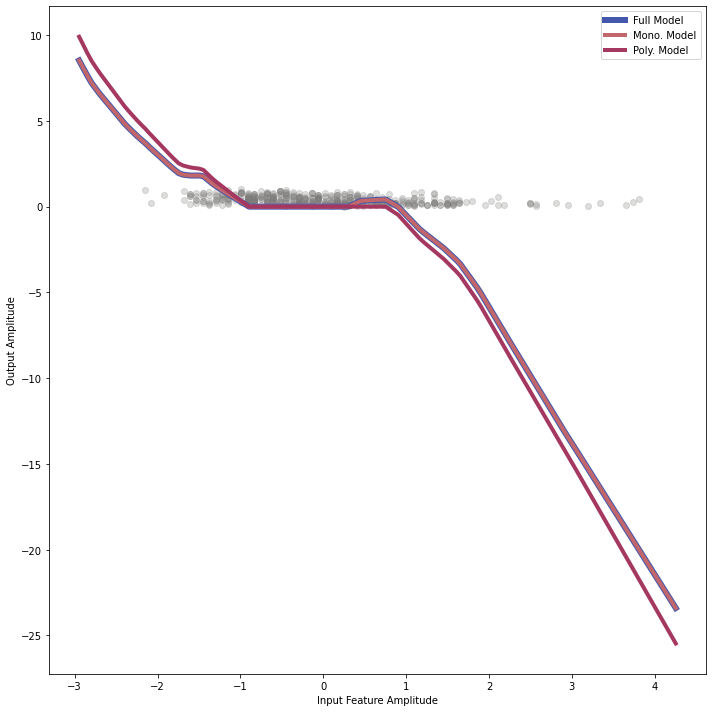

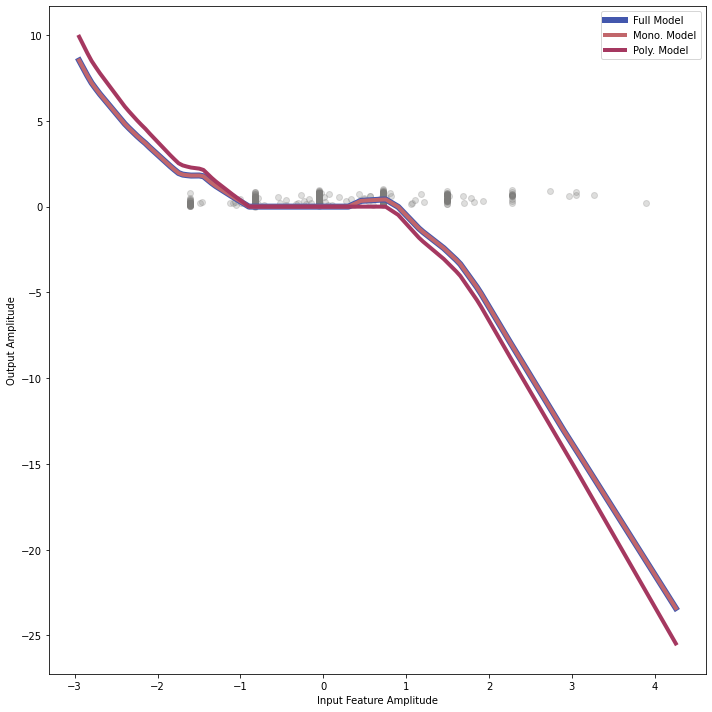

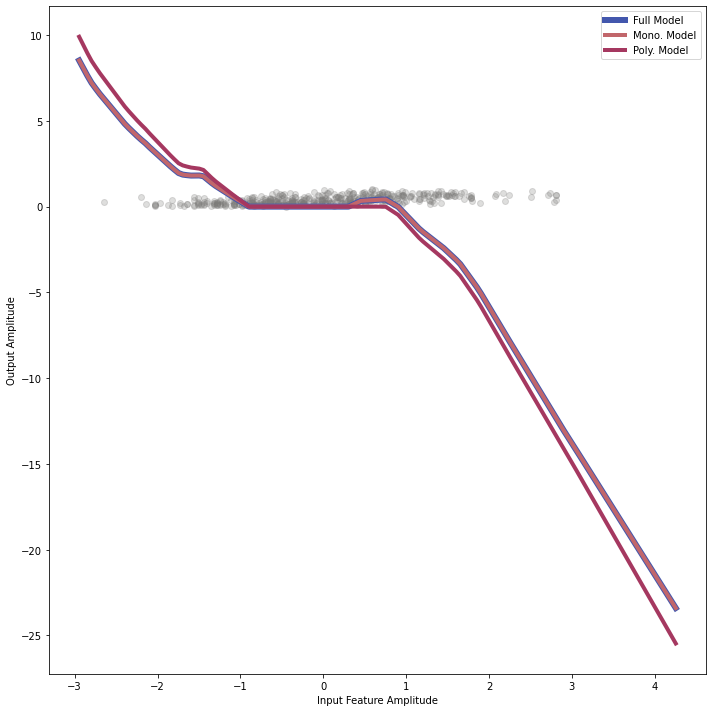

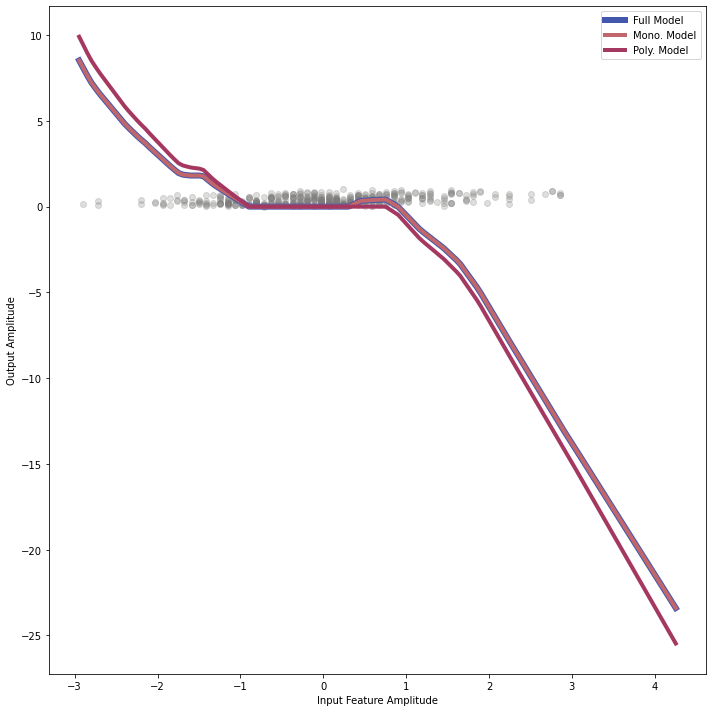

In [14]:
full_os = np.array(full_os)
mono_os = np.array(mono_os)
poly_os = np.array(poly_os)

print(full_os.shape)

for i in range(m):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(inputs[:, i], vectors, color='#7D7C7A', alpha=0.25)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), full_os[:,i], '-',
             label='Full Model', color=clist[0], lw=6)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), mono_os[:,i], '-',
             label='Mono. Model', color=clist[3], lw=4)
    plt.plot(np.arange(min_i - step_size, max_i + 2*step_size, step_size), poly_os[:,i], '-',
             label='Poly. Model', color=clist[4], lw=4)
    # plt.plot([0, 1], [0, 1], 'k--', label='Truth')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.xlabel('Input Feature Amplitude')
    plt.ylabel('Output Amplitude')
    plt.legend()
    
    fig.tight_layout()
    plt.show()